# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter none.

In [23]:
from datetime import datetime
print(datetime.now())

2023-04-04 19:31:38.076532


In [24]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [25]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [26]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [27]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [28]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [29]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [30]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 19:31:39.247187
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                65664     
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [31]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [32]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
        print('Debug separator.load()')
        print('filename',filename)
        print('num val_genes',len(self.val_genes))
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 19:31:39.436800
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
num val_genes 1028
2023-04-04 19:31:57.822790

Training # 1 1
2023-04-04 19:31:57.822964
2023-04-04 19:31:57.823019
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-04-04 19:31:57.899003


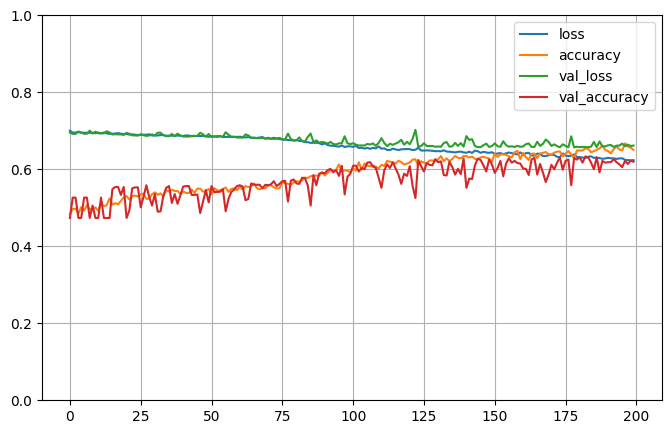


2023-04-04 19:34:04.622183

Testing # 1 1
2023-04-04 19:34:04.622306
2023-04-04 19:34:04.622353
PREDICT
2023-04-04 19:34:04.637400
Test 1:0 458:412 52.64%
Predict 1:0 623:247 71.61%
Test sizes (870, 1025) (870,)
Range of scores: 0.0154581545 to 0.95916784
Score threshold 0.5
Confusion matrix
 [[164 248]
 [ 83 375]]
Normalized matrix
 [[0.18850575 0.28505747]
 [0.0954023  0.43103448]]


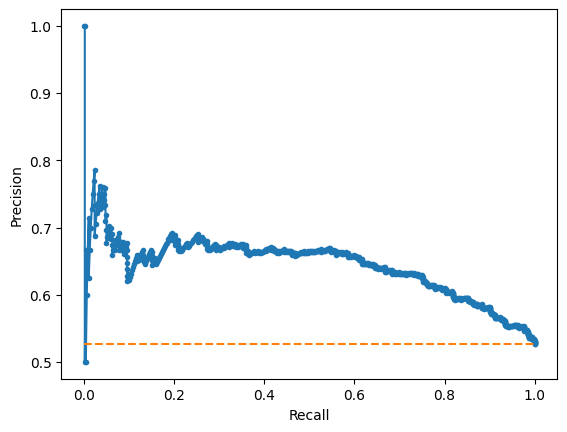

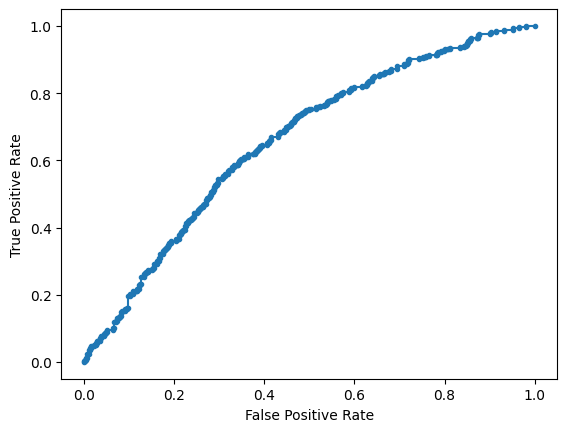

Accuracy: 61.95% Precision: 60.19% Recall: 81.88%
F1: 69.38% MCC: 0.2401
AUPRC: 64.39% AUROC: 65.85%
 accuracy [61.954022988505756]
 precision [60.19261637239165]
 recall [81.87772925764192]
 F1 [69.38020351526364]
 MCC [0.24011501749825984]
 AUPRC [64.3942699526487]
 AUROC [65.85195234663162]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
num val_genes 1028
2023-04-04 19:34:05.456805

Training # 1 2
2023-04-04 19:34:05.457511
2023-04-04 19:34:05.457574
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-04-04 19:34:05.541195


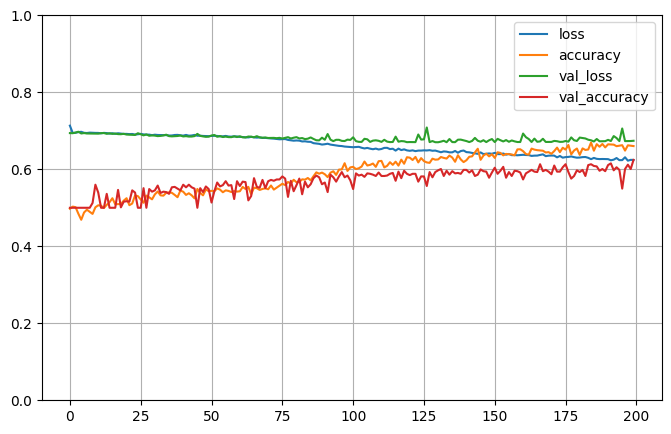


2023-04-04 19:35:37.030264

Testing # 1 2
2023-04-04 19:35:37.031686
2023-04-04 19:35:37.031737
PREDICT
2023-04-04 19:35:37.040056
Test 1:0 442:442 50.00%
Predict 1:0 532:352 60.18%
Test sizes (884, 1025) (884,)
Range of scores: 0.020037523 to 0.98833036
Score threshold 0.5
Confusion matrix
 [[231 211]
 [121 321]]
Normalized matrix
 [[0.26131222 0.23868778]
 [0.13687783 0.36312217]]


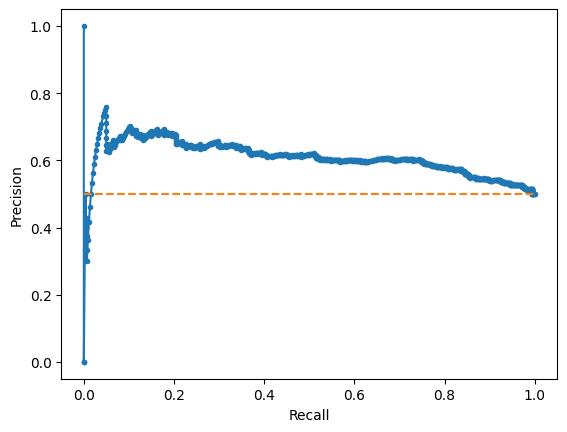

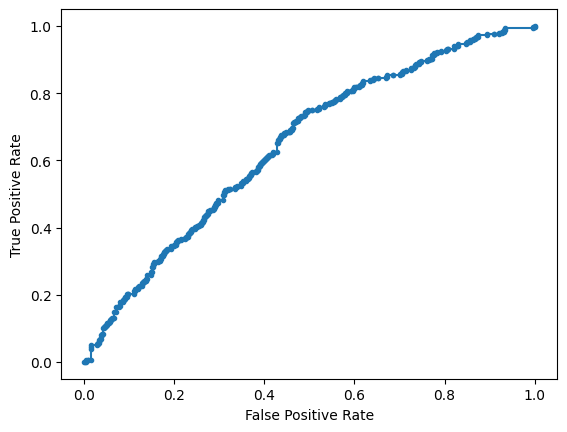

Accuracy: 62.44% Precision: 60.34% Recall: 72.62%
F1: 65.91% MCC: 0.2542
AUPRC: 60.74% AUROC: 64.49%
 accuracy [62.44343891402715]
 precision [60.338345864661655]
 recall [72.62443438914026]
 F1 [65.91375770020534]
 MCC [0.25419414165974663]
 AUPRC [60.74152764963667]
 AUROC [64.48833971458407]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
num val_genes 1028
2023-04-04 19:35:37.842402

Training # 1 3
2023-04-04 19:35:37.843626
2023-04-04 19:35:37.843681
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-04-04 19:35:37.937133


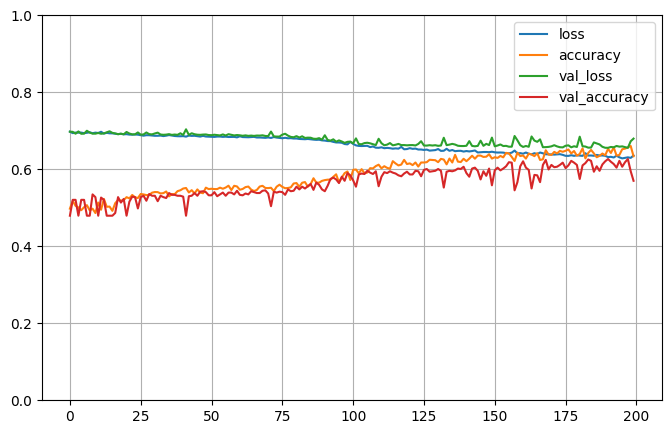


2023-04-04 19:38:01.279369

Testing # 1 3
2023-04-04 19:38:01.281712
2023-04-04 19:38:01.282261
PREDICT
2023-04-04 19:38:01.303632
Test 1:0 442:407 52.06%
Predict 1:0 199:650 23.44%
Test sizes (849, 1025) (849,)
Range of scores: 0.028949415 to 0.9310247
Score threshold 0.5
Confusion matrix
 [[346  61]
 [304 138]]
Normalized matrix
 [[0.40753828 0.07184923]
 [0.35806832 0.16254417]]


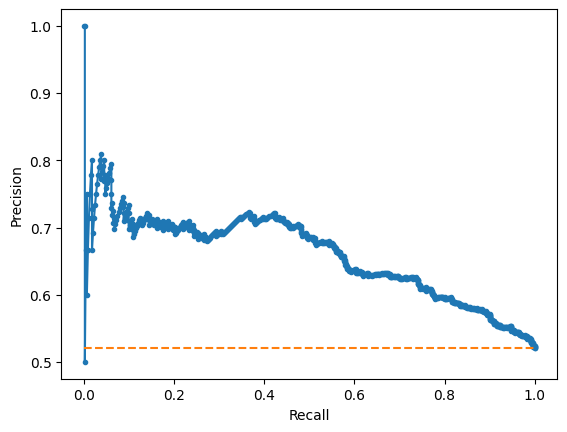

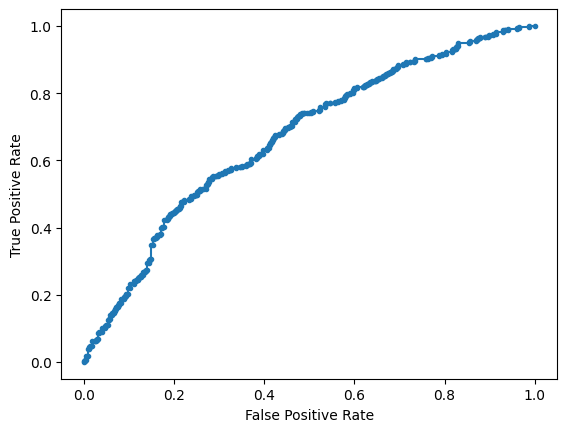

Accuracy: 57.01% Precision: 69.35% Recall: 31.22%
F1: 43.06% MCC: 0.1914
AUPRC: 65.94% AUROC: 66.79%
 accuracy [57.008244994110726]
 precision [69.34673366834171]
 recall [31.221719457013574]
 F1 [43.05772230889236]
 MCC [0.19144797804358465]
 AUPRC [65.94096134036656]
 AUROC [66.78544031485207]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
num val_genes 1028
2023-04-04 19:38:02.498867

Training # 1 4
2023-04-04 19:38:02.500493
2023-04-04 19:38:02.500598
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-04-04 19:38:02.649693


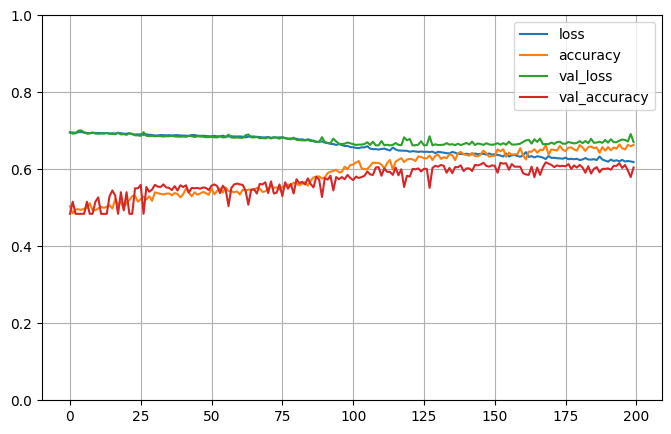


2023-04-04 19:40:26.349942

Testing # 1 4
2023-04-04 19:40:26.350345
2023-04-04 19:40:26.350418
PREDICT
2023-04-04 19:40:26.364682
Test 1:0 459:431 51.57%
Predict 1:0 561:329 63.03%
Test sizes (890, 1025) (890,)
Range of scores: 0.012627351 to 0.96054363
Score threshold 0.5
Confusion matrix
 [[204 227]
 [125 334]]
Normalized matrix
 [[0.22921348 0.25505618]
 [0.14044944 0.3752809 ]]


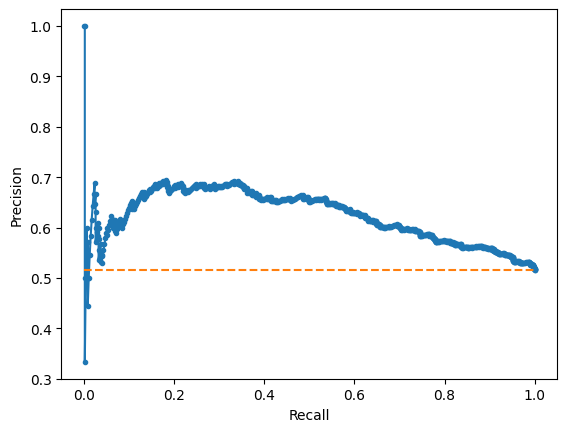

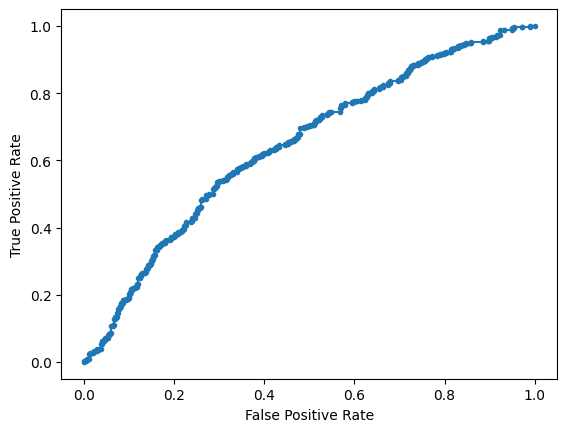

Accuracy: 60.45% Precision: 59.54% Recall: 72.77%
F1: 65.49% MCC: 0.2081
AUPRC: 62.30% AUROC: 64.42%
 accuracy [60.449438202247194]
 precision [59.53654188948306]
 recall [72.76688453159042]
 F1 [65.49019607843137]
 MCC [0.20808124660585892]
 AUPRC [62.30101560204111]
 AUROC [64.41977667581598]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
num val_genes 1027
2023-04-04 19:40:27.218598

Training # 1 5
2023-04-04 19:40:27.218796
2023-04-04 19:40:27.218846
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-04-04 19:40:27.321050


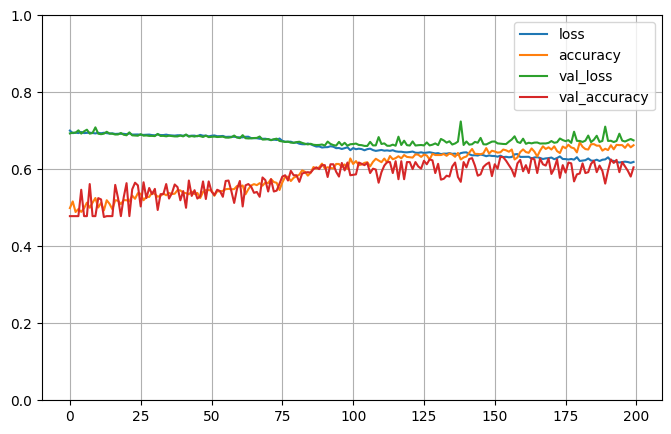


2023-04-04 19:41:55.939981

Testing # 1 5
2023-04-04 19:41:55.940128
2023-04-04 19:41:55.940175
PREDICT
2023-04-04 19:41:55.952245
Test 1:0 457:419 52.17%
Predict 1:0 617:259 70.43%
Test sizes (876, 1025) (876,)
Range of scores: 0.005120755 to 0.9681769
Score threshold 0.5
Confusion matrix
 [[166 253]
 [ 93 364]]
Normalized matrix
 [[0.18949772 0.28881279]
 [0.10616438 0.41552511]]


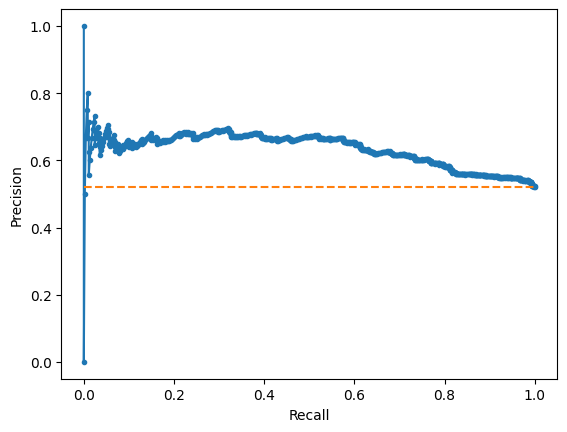

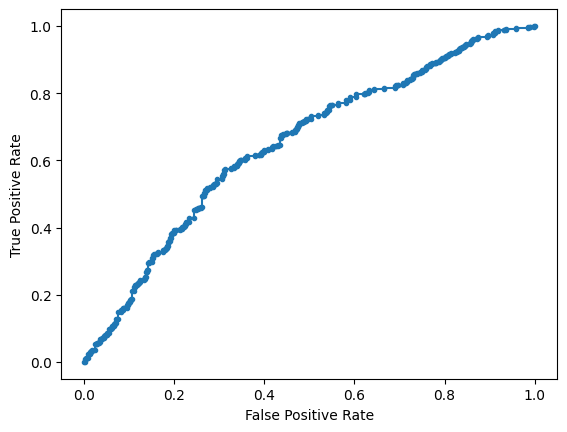

Accuracy: 60.50% Precision: 59.00% Recall: 79.65%
F1: 67.78% MCC: 0.2109
AUPRC: 63.29% AUROC: 64.69%
 accuracy [60.50228310502283]
 precision [58.995137763371154]
 recall [79.64989059080962]
 F1 [67.78398510242086]
 MCC [0.2109162004373343]
 AUPRC [63.28519171534196]
 AUROC [64.68772684781416]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
num val_genes 1028
2023-04-04 19:41:57.040507

Training # 2 1
2023-04-04 19:41:57.042604
2023-04-04 19:41:57.043022
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-04-04 19:41:57.164741


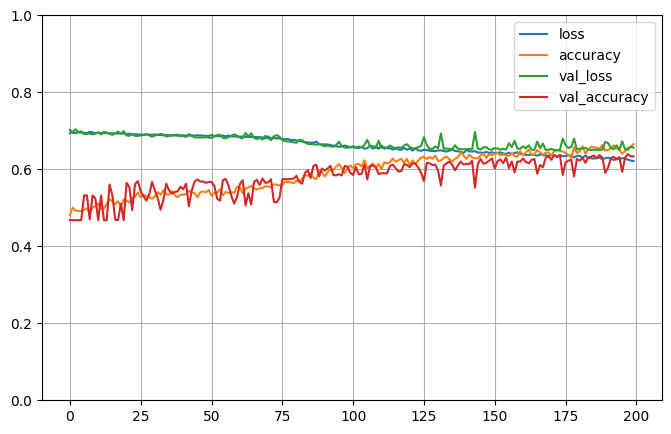


2023-04-04 19:43:32.282159

Testing # 2 1
2023-04-04 19:43:32.282244
2023-04-04 19:43:32.282278
PREDICT
2023-04-04 19:43:32.289443
Test 1:0 472:415 53.21%
Predict 1:0 431:456 48.59%
Test sizes (887, 1025) (887,)
Range of scores: 0.021936057 to 0.98109007
Score threshold 0.5
Confusion matrix
 [[273 142]
 [183 289]]
Normalized matrix
 [[0.30777903 0.16009019]
 [0.20631342 0.32581736]]


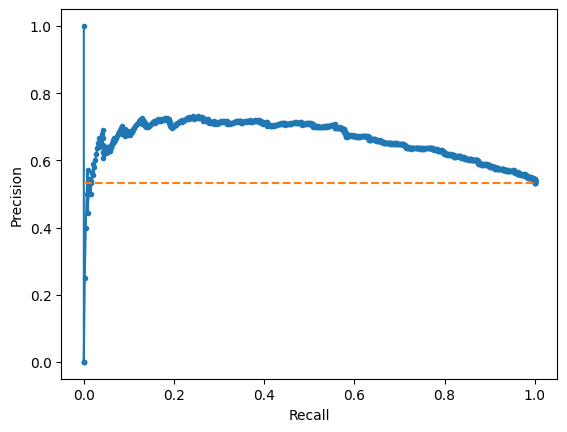

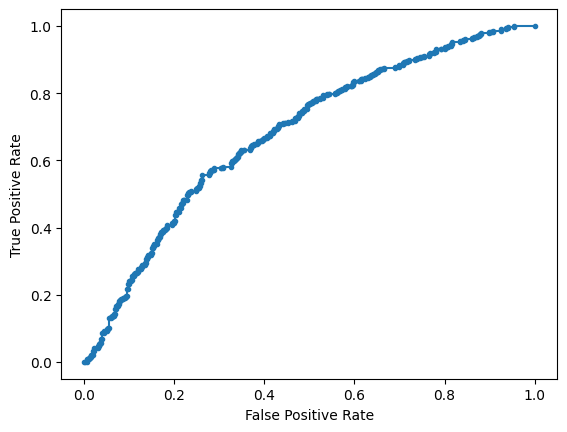

Accuracy: 63.36% Precision: 67.05% Recall: 61.23%
F1: 64.01% MCC: 0.2697
AUPRC: 66.24% AUROC: 68.03%
 accuracy [63.35963923337091]
 precision [67.05336426914154]
 recall [61.228813559322035]
 F1 [64.00885935769658]
 MCC [0.26966828025247613]
 AUPRC [66.23961851916394]
 AUROC [68.03042679191341]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
num val_genes 1028
2023-04-04 19:43:34.262665

Training # 2 2
2023-04-04 19:43:34.264736
2023-04-04 19:43:34.265174
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-04-04 19:43:34.384829


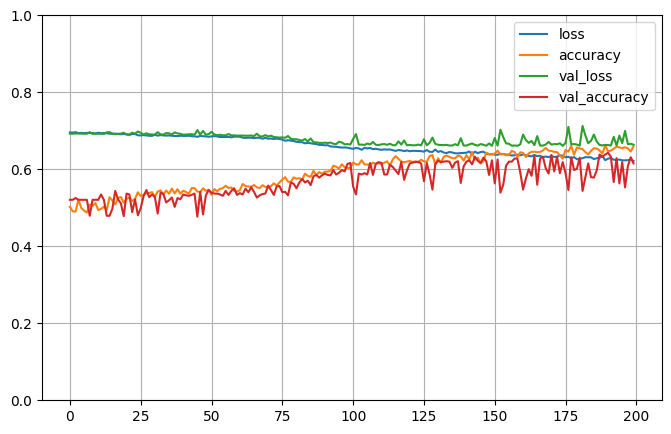


2023-04-04 19:45:11.281692

Testing # 2 2
2023-04-04 19:45:11.283403
2023-04-04 19:45:11.283799
PREDICT
2023-04-04 19:45:11.295763
Test 1:0 452:416 52.07%
Predict 1:0 612:256 70.51%
Test sizes (868, 1025) (868,)
Range of scores: 0.020084389 to 0.97095245
Score threshold 0.5
Confusion matrix
 [[169 247]
 [ 87 365]]
Normalized matrix
 [[0.19470046 0.28456221]
 [0.10023041 0.42050691]]


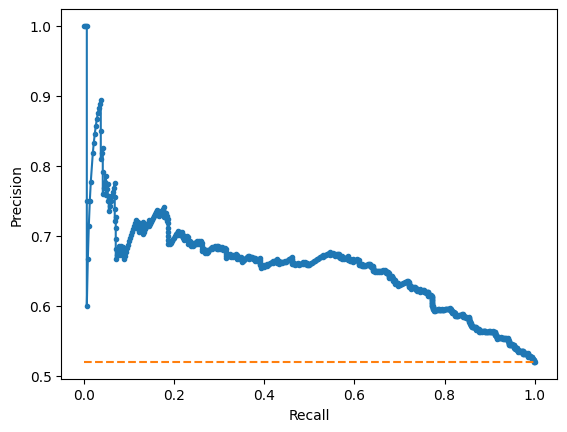

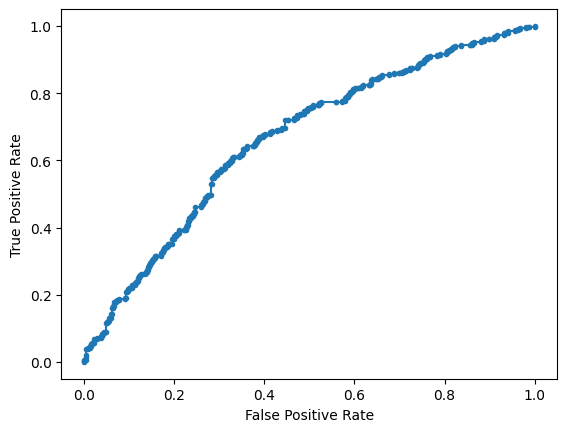

Accuracy: 61.52% Precision: 59.64% Recall: 80.75%
F1: 68.61% MCC: 0.2342
AUPRC: 65.67% AUROC: 66.30%
 accuracy [61.52073732718893]
 precision [59.64052287581699]
 recall [80.75221238938053]
 F1 [68.60902255639098]
 MCC [0.23419157163200685]
 AUPRC [65.6697475296869]
 AUROC [66.29828965282505]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
num val_genes 1028
2023-04-04 19:45:12.569128

Training # 2 3
2023-04-04 19:45:12.571164
2023-04-04 19:45:12.571562
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-04-04 19:45:12.717234


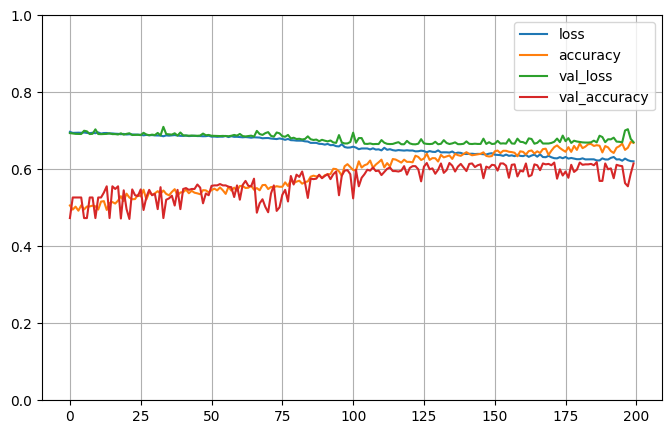


2023-04-04 19:47:36.698448

Testing # 2 3
2023-04-04 19:47:36.698560
2023-04-04 19:47:36.698606
PREDICT
2023-04-04 19:47:36.710525
Test 1:0 453:407 52.67%
Predict 1:0 500:360 58.14%
Test sizes (860, 1025) (860,)
Range of scores: 0.008108471 to 0.94959414
Score threshold 0.5
Confusion matrix
 [[218 189]
 [142 311]]
Normalized matrix
 [[0.25348837 0.21976744]
 [0.16511628 0.36162791]]


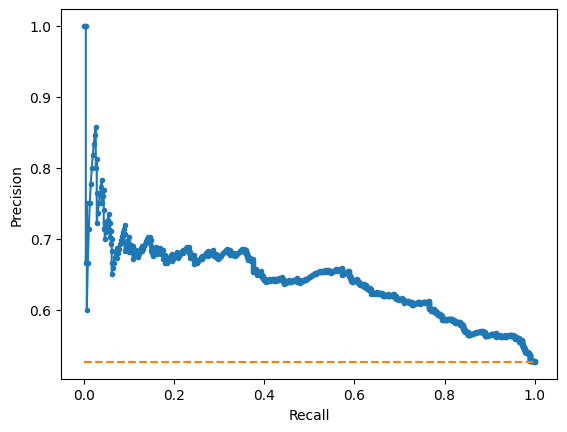

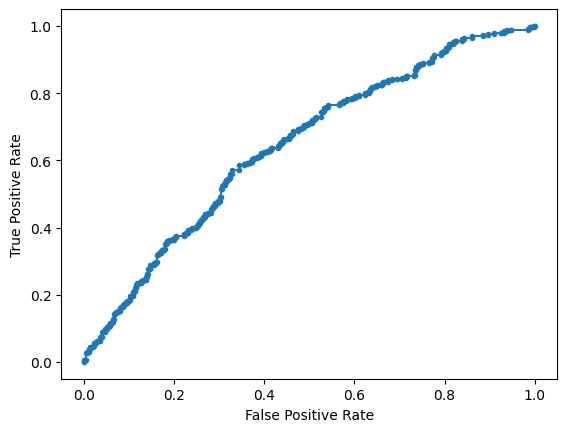

Accuracy: 61.51% Precision: 62.20% Recall: 68.65%
F1: 65.27% MCC: 0.2248
AUPRC: 64.24% AUROC: 64.41%
 accuracy [61.51162790697674]
 precision [62.2]
 recall [68.65342163355407]
 F1 [65.26757607555088]
 MCC [0.22484197414044]
 AUPRC [64.23927036912609]
 AUROC [64.40926176025513]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
num val_genes 1028
2023-04-04 19:47:37.577149

Training # 2 4
2023-04-04 19:47:37.577395
2023-04-04 19:47:37.577454
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-04-04 19:47:37.680336


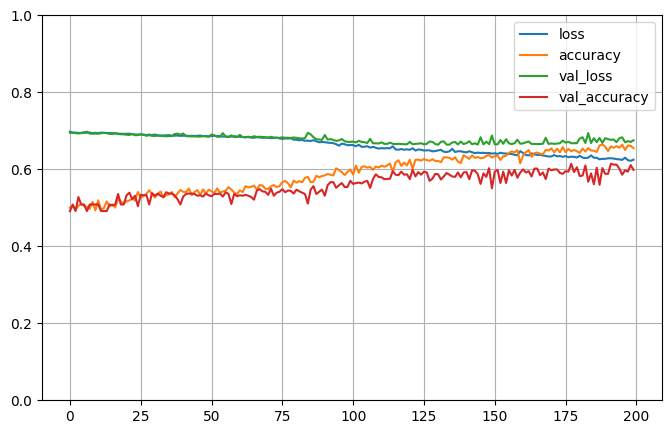


2023-04-04 19:50:00.902216

Testing # 2 4
2023-04-04 19:50:00.902335
2023-04-04 19:50:00.902387
PREDICT
2023-04-04 19:50:00.913465
Test 1:0 432:447 49.15%
Predict 1:0 301:578 34.24%
Test sizes (879, 1025) (879,)
Range of scores: 0.008619067 to 0.91268086
Score threshold 0.5
Confusion matrix
 [[336 111]
 [242 190]]
Normalized matrix
 [[0.38225256 0.12627986]
 [0.27531286 0.21615472]]


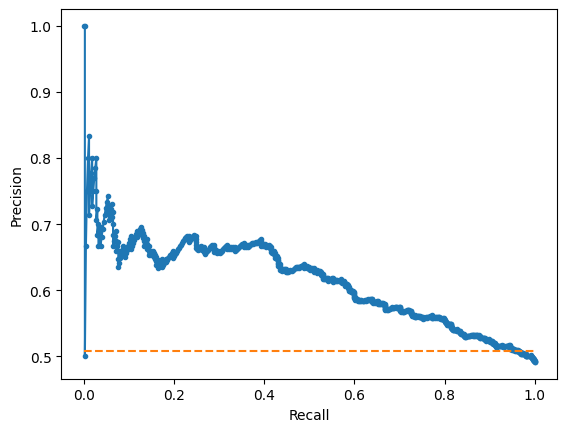

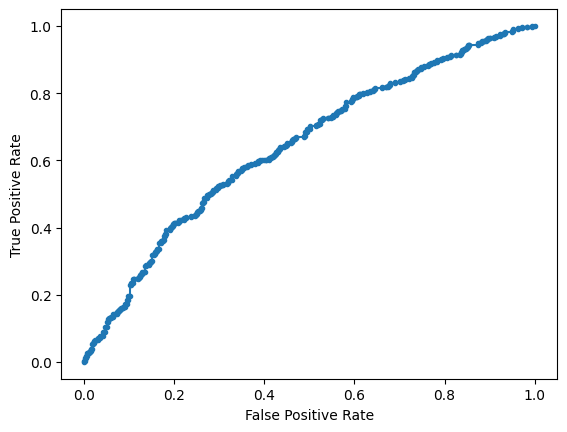

Accuracy: 59.84% Precision: 63.12% Recall: 43.98%
F1: 51.84% MCC: 0.2017
AUPRC: 61.48% AUROC: 64.17%
 accuracy [59.84072810011376]
 precision [63.12292358803987]
 recall [43.98148148148148]
 F1 [51.84174624829468]
 MCC [0.20174399477525382]
 AUPRC [61.48163010695227]
 AUROC [64.16956665838097]
Debug separator.load()
filename /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
num val_genes 1027
2023-04-04 19:50:01.794443

Training # 2 5
2023-04-04 19:50:01.796102
2023-04-04 19:50:01.796186
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-04-04 19:50:01.890104


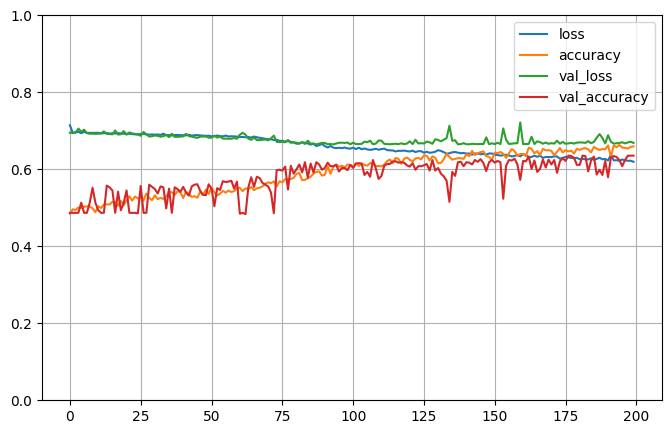


2023-04-04 19:51:39.332117

Testing # 2 5
2023-04-04 19:51:39.335096
2023-04-04 19:51:39.335481
PREDICT
2023-04-04 19:51:39.347066
Test 1:0 449:426 51.31%
Predict 1:0 472:403 53.94%
Test sizes (875, 1025) (875,)
Range of scores: 0.012727201 to 0.96899277
Score threshold 0.5
Confusion matrix
 [[255 171]
 [148 301]]
Normalized matrix
 [[0.29142857 0.19542857]
 [0.16914286 0.344     ]]


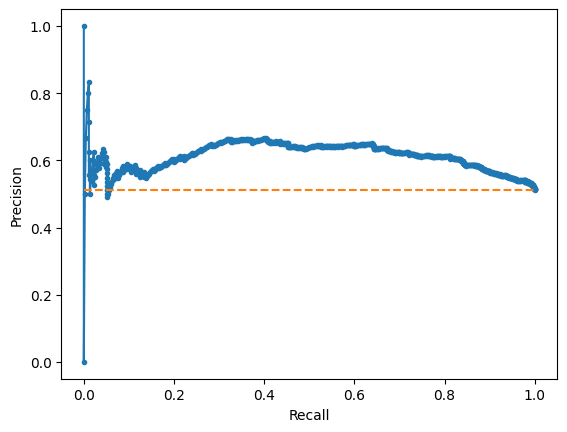

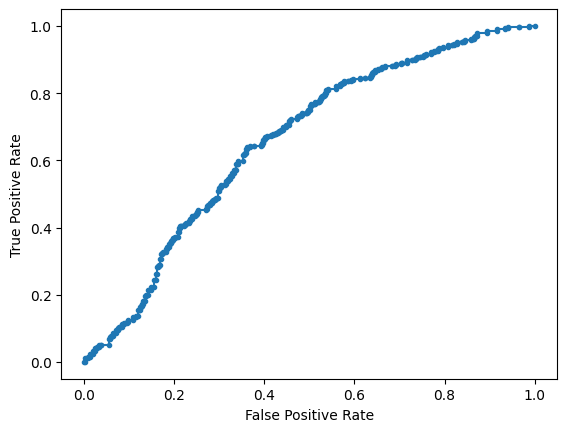

Accuracy: 63.54% Precision: 63.77% Recall: 67.04%
F1: 65.36% MCC: 0.2697
AUPRC: 61.14% AUROC: 65.74%
 accuracy [63.542857142857144]
 precision [63.771186440677965]
 recall [67.03786191536749]
 F1 [65.36373507057546]
 MCC [0.26971715038767213]
 AUPRC [61.14057997929615]
 AUROC [65.735541683658]
2023-04-04 19:51:39.981593


In [33]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [34]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.21% std 1.91
 precision mean 62.42% std 3.48
 recall mean 65.98% std 16.57
 F1 mean 62.67% std 8.45
 MCC mean 0.23% std 0.03
 AUPRC mean 63.54% std 2.06
 AUROC mean 65.49% std 1.28
 accuracy [[61.954022988505756], [62.44343891402715], [57.008244994110726], [60.449438202247194], [60.50228310502283], [63.35963923337091], [61.52073732718893], [61.51162790697674], [59.84072810011376], [63.542857142857144]]
 precision [[60.19261637239165], [60.338345864661655], [69.34673366834171], [59.53654188948306], [58.995137763371154], [67.05336426914154], [59.64052287581699], [62.2], [63.12292358803987], [63.771186440677965]]
 recall [[81.87772925764192], [72.62443438914026], [31.221719457013574], [72.76688453159042], [79.64989059080962], [61.228813559322035], [80.75221238938053], [68.65342163355407], [43.98148148148148], [67.03786191536749]]
 F1 [[69.38020351526364], [65.91375770020534], [43.05772230889236], [65.49019607843137], [67.78398510242086], [64.00885935769658], [68.60902255